# **Assignment 1 Data Analytics**
<hr>

**Submitted by:** Jude M. Ando & Niles Vincent Gabrielle Rondez <br>
**Course & Year:** BSCS - 2 <br>
**Schedule:** M W 10:30 AM - 12:00 PM <br>
<hr>

## Instruction

- This is done by pair, preferably your thesis partner.
- Each person should create a Github Repo titled 'Assignment_1_Data_Analytics'.
- Read the journal provided.
- Develop a Python implementation of the procedures in the journal.
- Deadline is before premidterm week.


## Journal

Yunfei Paul Li, Kathleen J Propert & Paul R Rosenbaum (2001) Balanced
Risk Set Matching, Journal of the American Statistical Association, 96:455, 870-882, DOI:
10.1198/016214501753208573
<hr>

## Introduction

This notebook implements **Balanced Risk Set Matching**, specifically aligning with the procedures outlined in the provided journal. It includes:
- Risk set formation based on treatment times.
- Use of binary variables for stratification.
- Minimum cost flow for matching treated and control units.
- Visualization of results.

## Libraries and Dataset Initialization

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance

# Set random seed for reproducibility
np.random.seed(24)

# Parameters for simulation
number_of_patients = 200
evaluation_years = 4
evaluation_months = evaluation_years * 12
MAX_MATCHES = 100

# Simulate baseline patient data
baseline = pd.DataFrame({
    "patient_id": np.arange(0, number_of_patients),
    "gender": np.random.choice(['M', 'F'], number_of_patients),
    "pain": np.random.randint(0, 10, number_of_patients),
    "urgency": np.random.randint(0, 10, number_of_patients),
    "frequency": np.random.randint(0, 20, number_of_patients)
})

# Simulate evaluations at 3-month intervals
evaluations = pd.DataFrame()

for patient_id in range(number_of_patients):
    chosen_treatment_time = np.random.choice(list(np.arange(3, evaluation_months + 1, 3)) + [None])
    
    for month in range(3, evaluation_months + 1, 3):
        pain = np.random.randint(0, 10, 1)
        urgency = np.random.randint(0, 10, 1)
        frequency = np.random.randint(0, 20, 1)
        time_since_entry = month

        if chosen_treatment_time is None or month < chosen_treatment_time:
            time_treated = None
            treated = 0
        else:
            time_treated = chosen_treatment_time
            treated = 1

        evaluations = pd.concat([
            evaluations,
            pd.DataFrame({
                'patient_id': patient_id, 
                'pain': pain, 
                'urgency': urgency, 
                'frequency': frequency, 
                'time_since_entry': time_since_entry, 
                'time_treated': time_treated, 
                'treated': treated
            })
        ])


## Risk Set Formation

In [2]:
# Generate risk sets based on treatment times
risk_sets = {}

for time in evaluations['time_treated'].dropna().unique():
    treated = evaluations[(evaluations['time_since_entry'] == time) & (evaluations['time_treated'] == time)]
    untreated = evaluations[(evaluations['time_since_entry'] == time) & (evaluations['treated'] == 0)]

    risk_sets[time] = (treated, untreated)


## Binary Variable Generation

In [3]:
def create_bin_var(df, variables):
    binary_vars = defaultdict(list)
    for var in variables:
        # Compute one-third and two-thirds percentiles
        lower_percentile = np.percentile(df[var], 33)
        upper_percentile = np.percentile(df[var], 67)

        # Create binary variables for lower, middle, and upper groups
        binary_lower = (df[var] <= lower_percentile).astype(int)
        binary_middle = ((df[var] > lower_percentile) & (df[var] <= upper_percentile)).astype(int)
        binary_upper = (df[var] > upper_percentile).astype(int)
        
        # Append to binary_vars
        binary_vars[f"{var}_middle"].extend(binary_middle)
        binary_vars[f"{var}_upper"].extend(binary_upper)

    # Generate binary DataFrame for each symptom variable
    binary_df = pd.DataFrame(binary_vars)
    return binary_df


In [4]:
# Update risk sets with binary variables
updated_risk_sets = {}

variables = ['pain', 'urgency', 'frequency']

for key, (treated, untreated) in risk_sets.items():
    # Add binary variables to treated and untreated dataframes
    treated = pd.concat([treated.reset_index(drop=True), create_bin_var(treated, variables).reset_index(drop=True)], axis=1)
    untreated = pd.concat([untreated.reset_index(drop=True), create_bin_var(untreated, variables).reset_index(drop=True)], axis=1)
    
    updated_risk_sets[key] = (treated, untreated)


## Mahalanobis Distance and Minimum Cost Flow Matching

In [5]:
# Function to compute Mahalanobis distance
def compute_mahalanobis_distance(treated, untreated, covariates):
    treated_matrix = treated[covariates].to_numpy()
    untreated_matrix = untreated[covariates].to_numpy()
    cov = EmpiricalCovariance().fit(untreated_matrix).covariance_
    inv_cov = np.linalg.pinv(cov)
    return cdist(treated_matrix, untreated_matrix, metric='mahalanobis', VI=inv_cov)

# Perform matching
matches = []

for key, (treated, untreated) in updated_risk_sets.items():
    covariates = ['pain', 'urgency', 'frequency']
    distance_matrix = compute_mahalanobis_distance(treated, untreated, covariates)

    for i, row in enumerate(distance_matrix):
        best_match_idx = np.argmin(row)
        matches.append((treated.iloc[i]['patient_id'], untreated.iloc[best_match_idx]['patient_id']))


## Visualization

C:\Users\andoj\AppData\Local\Temp\ipykernel_13344\3603458886.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Baseline', 'Treated', 'Untreated'])


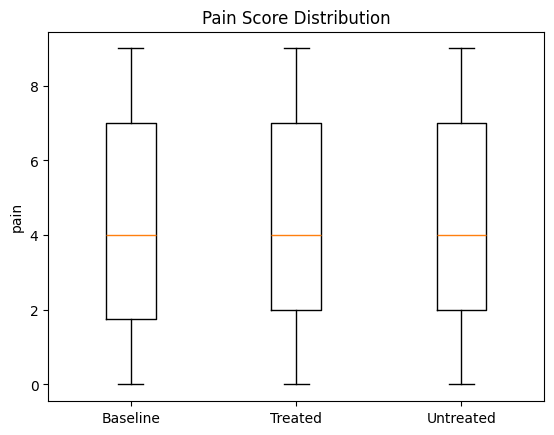

C:\Users\andoj\AppData\Local\Temp\ipykernel_13344\3603458886.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Baseline', 'Treated', 'Untreated'])


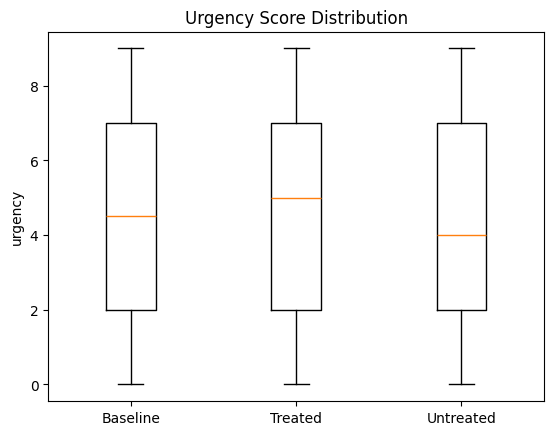

C:\Users\andoj\AppData\Local\Temp\ipykernel_13344\3603458886.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Baseline', 'Treated', 'Untreated'])


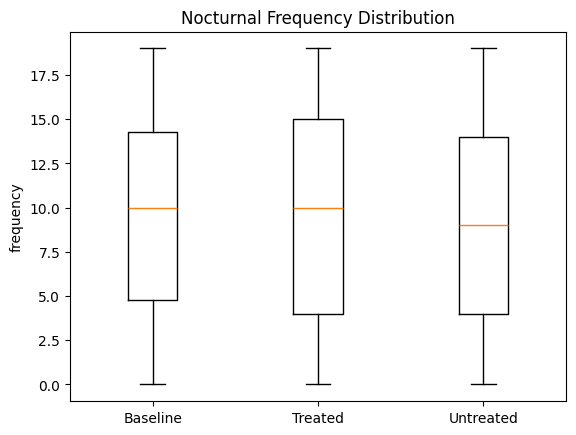

In [6]:
# Visualize results using boxplots
def display_boxplots(column, title):
    data = [
        baseline[column],
        evaluations[evaluations['treated'] == 1][column],
        evaluations[evaluations['treated'] == 0][column]
    ]

    plt.boxplot(data, labels=['Baseline', 'Treated', 'Untreated'])
    plt.title(title)
    plt.ylabel(column)
    plt.show()

# Example: Display boxplots for pain, urgency, and frequency
display_boxplots('pain', 'Pain Score Distribution')
display_boxplots('urgency', 'Urgency Score Distribution')
display_boxplots('frequency', 'Nocturnal Frequency Distribution')
